In [291]:
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.generation import MaxPosteriorSampling
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

from torch.quasirandom import SobolEngine
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from botorch.utils.transforms import unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from src.sim import MixtureModel
import matplotlib.pyplot as plt
from argparse import Namespace, ArgumentParser
import math
from dataclasses import dataclass

import glob
from PIL import Image
import matplotlib as mpl

from src.alg.algorithms import TopK
from src.models.simple_gp import SimpleGp
from src.acq.acquisition import (
    BaxAcqFunction, UsBaxAcqFunction, EigfBaxAcqFunction, RandBaxAcqFunction
)
from src.acq.acqoptimize import AcqOptimizer
from src.acq.visualize import AcqViz1D
from src.utils.domain_util import unif_random_sample_domain
from src.acq.acquisition import Base, AcqFunction
from src.utils.misc_util import dict_to_namespace
from src.alg.algorithms import AlgorithmSet
import copy
from copy import deepcopy
import matplotlib.cm as cm
import time
import datetime

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
class Timer(object):
    """
    Timer class. Thanks to Eli Bendersky, Josiah Yoder, Jonas Adler, Can Kavaklıoğlu,
    and others from https://stackoverflow.com/a/50957722.
    """
    def __init__(self, name=None, filename=None):
        self.name = name
        self.filename = filename

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        message = 'Elapsed: %.2f seconds' % (time.time() - self.tstart)
        if self.name:
            message = '*[TIME] [%s] ' % self.name + message
        print(message)
        if self.filename:
            with open(self.filename,'a') as file:
                print(str(datetime.datetime.now())+": ",message,file=file)
    
class AlgoAcqFunction(AcqFunction):
    """
    Class for computing acquisition functions involving algorithms, such as entropy
    search and BAX methods.
    """

    def __init__(self, params=None, model=None, algorithm=None, verbose=True):
        """
        Parameters
        ----------
        params : Namespace_or_dict
            Namespace or dict of parameters for the AcqFunction.
        model : SimpleGp
            Instance of a SimpleGp or child.
        algorithm : Algorithm
            Instance of an Algorithm or child.
        verbose : bool
            If True, print description string.
        """
        super().__init__(params, verbose)
        self.set_model(model)
        self.set_algorithm(algorithm)

    def set_params(self, params):
        """Set self.params, the parameters for the AcqFunction."""
        super().set_params(params)

        params = dict_to_namespace(params)
        self.params.name = getattr(params, 'name', 'AlgoAcqFunction')
        self.params.n_path = getattr(params, "n_path", 100)
        self.params.crop = getattr(params, "crop", True)

    def set_algorithm(self, algorithm):
        """Set self.algorithm for this acquisition function."""
        if not algorithm:
            raise ValueError("The algorithm input parameter cannot be None.")
        else:
            self.algorithm = algorithm.get_copy()

    def initialize(self):
        """
        Initialize the acquisition function before acquisition optimization. Draw
        samples of the execution path and algorithm output from functions sampled from
        the model.
        """
        exe_path_list, output_list, full_list = self.get_exe_path_and_output_samples()

        # Set self.output_list
        self.output_list = output_list
        self.exe_path_full_list = full_list

        # Set self.exe_path_list to list of full or cropped exe paths
        if self.params.crop:
            self.exe_path_list = exe_path_list
        else:
            self.exe_path_list = full_list

    def get_exe_path_and_output_samples_loop(self):
        """
        Return exe_path_list and output_list respectively containing self.params.n_path
        exe_path samples and associated outputs, using self.model and self.algorithm.
        """
        exe_path_list = []
        output_list = []
        with Timer(f"Sample {self.params.n_path} execution paths"):
            for _ in range(self.params.n_path):
                fs = FunctionSample(verbose=False)
                fs.set_model(self.model)
                exe_path, output = self.algorithm.run_algorithm_on_f(fs)
                exe_path_list.append(exe_path)
                output_list.append(output)

        return exe_path_list, output_list

    def get_exe_path_and_output_samples(self):
        """
        Return exe_path_list and output_list respectively containing self.params.n_path
        exe_path samples and associated outputs, using self.model and self.algorithm.
        """
        exe_path_list = []
        output_list = []
        with Timer(f"Sample {self.params.n_path} execution paths"):
            # Initialize model fsl
            # self.model.initialize_function_sample_list(self.params.n_path)

            # Run algorithm on function sample list
            #f_list = self.model.call_function_sample_list
            f_list = self.model.posterior
            algoset = AlgorithmSet(self.algorithm)
            exe_path_full_list, output_list = algoset.run_algorithm_on_f_list(
                f_list, self.params.n_path)

            # Get crop of each exe_path in exe_path_list
            #exe_path_list = algoset.get_exe_path_list_crop()

        return exe_path_list, output_list, exe_path_full_list
    
class BaxAcqFunction(AlgoAcqFunction):
    """
    Class for computing BAX acquisition functions.
    """

    def set_params(self, params):
        """Set self.params, the parameters for the AcqFunction."""
        super().set_params(params)

        params = dict_to_namespace(params)
        self.params.name = getattr(params, 'name', 'BaxAcqFunction')
        self.params.acq_str = getattr(params, "acq_str", "exe")
        self.params.min_neighbors = getattr(params, "min_neighbors", 10)
        self.params.max_neighbors = getattr(params, "max_neighbors", 30)
        self.params.dist_thresh = getattr(params, "dist_thresh", 1.0)
        self.params.dist_thresh_init = getattr(params, "dist_thresh_init", 20.0)
        self.params.dist_thresh_inc = getattr(params, "dist_thresh_inc", 0.5)
        self.params.min_n_clust = getattr(params, "min_n_clust", 5)

    def entropy_given_normal_std(self, std_arr):
        """Return entropy given an array of 1D normal standard deviations."""
        std_arr = std_arr.detach().cpu()
        entropy = np.log(std_arr) + np.log(np.sqrt(2 * np.pi)) + 0.5
        return entropy

    def acq_exe_normal(self, post_std, samp_std_list):
        """
        Execution-path-based acquisition function: EIG on the execution path, via
        predictive entropy, for normal posterior predictive distributions.
        """

        # Compute entropies for posterior predictive
        h_post = self.entropy_given_normal_std(post_std)

        # Compute entropies for posterior predictive given execution path samples
        h_samp_list = []
        for samp_std in samp_std_list:
            h_samp = self.entropy_given_normal_std(samp_std)
            h_samp_list.append(h_samp)

        avg_h_samp = np.mean(h_samp_list, 0)
        acq_exe = h_post - avg_h_samp
        return acq_exe

    def acq_out_normal(self, post_std, samp_mean_list, samp_std_list, output_list):
        """
        Algorithm-output-based acquisition function: EIG on the algorithm output, via
        predictive entropy, for normal posterior predictive distributions.
        """
        # Compute entropies for posterior predictive
        h_post = self.entropy_given_normal_std(post_std)

        # Get list of idx-list-per-cluster
        dist_thresh = self.params.dist_thresh_init
        cluster_idx_list = self.get_cluster_idx_list(output_list, dist_thresh)

        # -----
        print('\t- clust_idx_list initial details:')
        len_list = [len(clust) for clust in cluster_idx_list]
        print(f'\t\t- min len_list: {np.min(len_list)},  max len_list: {np.max(len_list)},  len(len_list): {len(len_list)}')
        # -----

        # Filter clusters that are too small (looping to find optimal dist_thresh)
        min_nn = self.params.min_neighbors
        min_n_clust = self.params.min_n_clust
        min_dist_thresh = self.params.dist_thresh

        cluster_idx_list_new = [clust for clust in cluster_idx_list if len(clust) > min_nn]
        # -----
        print('\t- clust_idx_list_NEW details:')
        len_list = [len(clust) for clust in cluster_idx_list_new]
        print(f'\t\t- min len_list: {np.min(len_list)},  max len_list: {np.max(len_list)},  len(len_list): {len(len_list)}')
        # -----
        while len(cluster_idx_list_new) > min_n_clust and dist_thresh >= min_dist_thresh:
            cluster_idx_list_keep = cluster_idx_list_new
            dist_thresh -= self.params.dist_thresh_inc
            print(f'NOTE: dist_thresh = {dist_thresh}')
            cluster_idx_tmp = self.get_cluster_idx_list(output_list, dist_thresh)
            cluster_idx_list_new = [clust for clust in cluster_idx_tmp if len(clust) > min_nn]

        try:
            cluster_idx_list = cluster_idx_list_keep
        except UnboundLocalError:
            print(
                'WARNING: cluster_idx_list_keep not assigned, using cluster_idx_list.'
            )
            pass

        ## Only remove small clusters if there are enough big clusters
        #if len(cluster_idx_list_new) > self.params.min_n_clust:
            #cluster_idx_list = cluster_idx_list_new

        # -----
        len_list = [len(clust) for clust in cluster_idx_list]
        print('\t- clust_idx_list final details:')
        print(f'\t\t- min len_list: {np.min(len_list)},  max len_list: {np.max(len_list)},  len(len_list): {len(len_list)}')
        print(f'\t\tFound dist_thresh: {dist_thresh}')
        # -----

        # Compute entropies for posterior predictive given execution path samples
        h_cluster_list = []
        std_cluster_list = []
        mean_cluster_list = []
        for idx_list in cluster_idx_list:
            # Mean of the mixture
            samp_mean_cluster_list = [samp_mean_list[idx] for idx in idx_list]
            samp_mean_cluster = np.mean(samp_mean_cluster_list, 0)
            mean_cluster_list.append(samp_mean_cluster)

            # Std of the mixture
            samp_std_cluster_list = [samp_std_list[idx] for idx in idx_list]
            smcls = [smc**2 for smc in samp_mean_cluster_list]
            sscls = [ssc**2 for ssc in samp_std_cluster_list]
            sum_smcls_sscls = [smcs + sscs for smcs, sscs in zip(smcls, sscls)]
            samp_sec_moment_cluster = np.mean(sum_smcls_sscls, 0)
            samp_var_cluster = samp_sec_moment_cluster - samp_mean_cluster**2
            samp_std_cluster = np.sqrt(samp_var_cluster)
            std_cluster_list.append(samp_std_cluster)

            # Entropy of the Gaussian approximation to the mixture
            h_cluster = self.entropy_given_normal_std(samp_std_cluster)
            h_cluster_list.extend([h_cluster])

        avg_h_cluster = np.mean(h_cluster_list, 0)
        acq_out = h_post - avg_h_cluster

        # Store variables
        self.cluster_idx_list = cluster_idx_list
        self.mean_cluster_list = mean_cluster_list
        self.std_cluster_list = std_cluster_list

        return acq_out

    def get_cluster_idx_list(self, output_list, dist_thresh):
        """
        Cluster outputs in output_list (based on nearest neighbors, and using
        dist_thresh as a nearness threshold) and return list of idx-list-per-cluster.
        """

        # Build distance matrix
        dist_fn = self.algorithm.get_output_dist_fn()
        dist_mat = [[dist_fn(o1, o2) for o1 in output_list] for o2 in output_list]

        # Build idx_arr_list and dist_arr_list
        idx_arr_list = []
        dist_arr_list = []
        for row in dist_mat:
            idx_sort = np.argsort(row)
            dist_sort = np.array([row[i] for i in idx_sort])

            # Keep at most max_neighbors, as long as they are within dist_thresh
            dist_sort = dist_sort[:self.params.max_neighbors]
            row_idx_keep = np.where(dist_sort < dist_thresh)[0]

            idx_arr = idx_sort[row_idx_keep]
            idx_arr_list.append(idx_arr)

            dist_arr = dist_sort[row_idx_keep]
            dist_arr_list.append(dist_arr)

        return idx_arr_list

    def acq_is_normal(
        self, post_std, samp_mean_list, samp_std_list, output_list, x_list
    ):
        """
        Algorithm-output-based acquisition function: EIG on the algorithm output, via
        the importance sampling strategy, for normal posterior predictive distributions.
        """
        # Compute list of means and stds for full execution path
        samp_mean_list_full = []
        samp_std_list_full = []
        for exe_path in self.exe_path_full_list:
            comb_data = Namespace()
            comb_data.x = self.model.data.x + exe_path.x
            comb_data.y = self.model.data.y + exe_path.y
            samp_mean, samp_std = self.model.gp_post_wrapper(
                x_list, comb_data, full_cov=False
            )
            samp_mean_list_full.append(samp_mean)
            samp_std_list_full.append(samp_std)

        # Compute entropies for posterior predictive
        h_post = self.entropy_given_normal_std(post_std)

        # Get list of idx-list-per-cluster
        cluster_idx_list = self.get_cluster_idx_list(
            output_list, self.params.dist_thresh
        )

        # -----
        print('\t- clust_idx_list details:')
        len_list = [len(clust) for clust in cluster_idx_list]
        print(f'\t- min len_list: {np.min(len_list)},  max len_list: {np.max(len_list)},  len(len_list): {len(len_list)}')
        # -----

        ## Remove clusters that are too small
        #min_nn = self.params.min_neighbors
        #cluster_idx_list = [clust for clust in cluster_idx_list if len(clust) > min_nn]

        # -----
        len_list = [len(clust) for clust in cluster_idx_list]
        print(f'\t- min len_list: {np.min(len_list)},  max len_list: {np.max(len_list)},  len(len_list): {len(len_list)}')
        # -----

        # Compute entropies for posterior predictive given execution path samples
        h_samp_list = []
        #for samp_mean, samp_std in zip(samp_mean_list, samp_std_list):
        for exe_idx in range(len(samp_mean_list)):
            # Unpack
            samp_mean = samp_mean_list[exe_idx]
            samp_mean_full = samp_mean_list_full[exe_idx]
            samp_std = samp_std_list[exe_idx]
            samp_std_full = samp_std_list_full[exe_idx]
            clust_idx = cluster_idx_list[exe_idx]

            # Sample from proposal distribution
            n_samp = 200
            pow_fac = 0.001
            samp_mat = np.random.normal(samp_mean, samp_std, (n_samp, len(samp_mean)))

            # Compute importance weights denominators
            mean_mat = np.vstack([samp_mean for _ in range(n_samp)])
            std_mat = np.vstack([samp_std for _ in range(n_samp)])
            pdf_mat = sps_norm.pdf(samp_mat, mean_mat, std_mat)
            #weight_mat_den = np.ones(pdf_mat.shape)
            weight_mat_den = pdf_mat

            # Compute importance weights numerators
            pdf_mat_sum = np.zeros(pdf_mat.shape)
            for idx in clust_idx:
                samp_mean_full = samp_mean_list_full[idx]
                samp_std_full = samp_std_list_full[idx]

                mean_mat = np.vstack([samp_mean_full for _ in range(n_samp)])
                std_mat = np.vstack([samp_std_full for _ in range(n_samp)])
                pdf_mat = sps_norm.pdf(samp_mat, mean_mat, std_mat)
                pdf_mat_sum = pdf_mat_sum + pdf_mat

            #weight_mat_num = np.ones(pdf_mat_sum.shape)
            weight_mat_num = pdf_mat_sum / len(clust_idx)
            weight_mat_num = weight_mat_num

            # Compute and normalize importance weights
            weight_mat = (weight_mat_num + 1e-50) / (weight_mat_den + 1.1e-50)
            weight_mat_norm = weight_mat / np.sum(weight_mat, 0)
            weight_mat_norm = (n_samp * weight_mat_norm) ** pow_fac

            # Reweight samples and compute statistics
            weight_samp = samp_mat * weight_mat_norm * n_samp
            is_mean = np.mean(weight_samp, 0)
            is_std = np.std(weight_samp, 0)
            h_samp = self.entropy_given_normal_std(is_std)
            h_samp_list.append(h_samp)

        avg_h_samp = np.mean(h_samp_list, 0)
        acq_is = h_post - avg_h_samp
        return acq_is

    def get_acq_list_batch(self, x_list):
        """Return acquisition function for a batch of inputs x_list."""

        with Timer(f"Compute acquisition function for a batch of {len(x_list)} points"):
            # Compute posterior, and post given each execution path sample, for x_list
            x_list = torch.tensor(x_list)
            post = self.model.posterior(x_list)
            mu, std = post.mean, post.variance.sqrt()

            # Compute mean and std arrays for posterior given execution path samples
            mu_list = []
            std_list = []
            for exe_path in self.exe_path_list:
                comb_data = Namespace()
                comb_data.x = self.model.data.x + exe_path.x
                comb_data.y = self.model.data.y + exe_path.y
                samp_mu, samp_std = self.model.gp_post_wrapper(
                    x_list, comb_data, full_cov=False
                )
                mu_list.append(samp_mu)
                std_list.append(samp_std)

            # Compute acq_list, the acqfunction value for each x in x_list
            if self.params.acq_str == "exe":
                acq_list = self.acq_exe_normal(std, std_list)
            elif self.params.acq_str == 'out':
                acq_list = self.acq_out_normal(std, mu_list, std_list, self.output_list)
            elif self.params.acq_str == 'is':
                acq_list = self.acq_is_normal(
                    std, mu_list, std_list, self.output_list, x_list
                )

        # Package and store acq_vars
        self.acq_vars = {
            "mu": mu,
            "std": std,
            "mu_list": mu_list,
            "std_list": std_list,
            "acq_list": acq_list,
        }

        # Return list of acquisition function on x in x_list
        return acq_list

    def __call__(self, x_list):
        """Class is callable and returns acquisition function on x_list."""
        acq_list = self.get_acq_list_batch(x_list)
        return acq_list

In [293]:
np.random.seed(1234)

# Set function
f = lambda x: np.sin(x) / x


# Set algorithm  details
n_dim = 1
domain = [[-10, 10]] * n_dim
len_path = 150
k = 10
x_path = unif_random_sample_domain(domain, len_path)
algo_gt = TopK({"x_path": x_path, "k": k})

*[INFO] Initialized TopK with params=Namespace(name='TopK', verbose=True, opt_mode='max', k=10, dist_str='norm')


In [ ]:
exepath_gt, output_gt = algo_gt.run_algorithm_on_f(f)

> /home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py(476)get_output()
    474         out_ns = Namespace()
    475         import pdb; pdb.set_trace()
--> 476         out_ns.x = [self.exe_path.x[idx] for idx in topk_idx]
    477         out_ns.y = [self.exe_path.y[idx] for idx in topk_idx]
    478 



In [283]:



print(f"Algorithm ground truth output is:\n{output_gt}")

# Set metric
def metric_jacc(x):
    # print(x, output_gt)
    x = np.array(x)
    output_gt = np.array(output_gt)
    return algo_gt.output_dist_fn_jaccard(x, output_gt)

metric_norm = lambda x: algo_gt.output_dist_fn_norm(x, output_gt)

# Set data for model
data = Namespace()
data.x = unif_random_sample_domain(domain, 128)
data.y = [f(x) for x in data.x]

X_tr, y_tr = torch.tensor(data.x), torch.tensor(data.y).unsqueeze(1)

# Set model details
likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
model = SingleTaskGP(X_tr, y_tr, likelihood=likelihood)

# Set acquisition details
acqfn_params = {"acq_str": "exe", "n_path": 100, "crop": True}
acq_cls = BaxAcqFunction

# Set acqopt details
n_acqopt = 1500

# Namespace to save results
results = Namespace(
    expected_metric_jacc_list = [], expected_metric_norm_list = []
)


Algorithm ground truth output is:
Namespace(x=[[8.035921027419842, 7.137458838690016], [7.581383230293515, 7.129549141191415], [-9.864718760199944, 8.609730668053313], [-3.6490635394560833, 8.071826941405966], [7.999303896733508, 2.6026622500458423], [2.1438741243696917, 7.62464492677854], [8.662802039650433, -5.687318740232083], [2.6745153790195815, 8.022790705005896], [-9.81302850999511, -4.866691356370241], [7.518652694841894, 1.3673516314586482]], y=[26.571200118717506, 25.281166042241207, 20.934090639098308, 19.308764369051175, 18.501438875521206, 18.452744663768215, 18.3445153951471, 18.226056118059002, 17.04757181623658, 16.878063122583885])


/tmp/ipykernel_5365/3983502374.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  X_tr, y_tr = torch.tensor(data.x), torch.tensor(data.y).unsqueeze(1)


BotorchTensorDimensionError: Expected X and Y to have the same number of dimensions (got X with dimension 2 and Y with dimension 3.

In [266]:
# Set and optimize acquisition function
acqfn = acq_cls(acqfn_params, model, algo_gt)

*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)


In [267]:
x_test = unif_random_sample_domain(domain, n=n_acqopt)
acqopt = AcqOptimizer({"x_batch": x_test})
x_next = acqopt.optimize(acqfn)

*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds


/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)
*[TIME] [Sample 100 execution paths] Elapsed: 0.61 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.00 seconds
Acqopt x_next = [1.5977268296262093, -2.829555643220183]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([-0.5

/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [8.889184181735505, 9.605223765438758]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.4459], dtype=torch.float64), tensor([16.9425], dtype=torch.float64), tensor([14.8512], dtype=torch.float64), tensor([14.5810], dtype=torch.float64), tensor([13.3472], dtype=torch.float64), tensor([12.8649], dtype=torch.float64), tensor([12.7592], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.94 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.02 seconds
Acqopt x_next = [-8.353477184355942, 5.371801820706391]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64)], y=[tensor([18.2726], dtype=torch.float64), tensor([17.4509], dtype=torch.float64), tensor([15.1284], dtype=torch.float64), tensor([14.3076], dtype=torch.float64), tensor([13.6414], dtype=torch.float64), tensor([12.5547], dtype=torch.float64), tensor([12.4282], dtype=torch.float64), tenso

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.62 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [1.7322227423058614, -9.084254749971121]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.6400], dtype=torch.float64), tensor([17.4900], dtype=torch.float64), tensor([14.6835], dtype=torch.float64), tensor([14.2836], dtype=torch.float64), tensor([13.7080], dtype=torch.float64), tensor([13.5200], dtype=torch.float64), tensor([12.3001], dtype=torch.float64), tens

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [-7.941632031954895, -1.6589257357356573]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64)], y=[tensor([18.1865], dtype=torch.float64), tensor([17.6111], dtype=torch.float64), tensor([15.2695], dtype=torch.float64), tensor([15.1710], dtype=torch.float64), tensor([13.6532], dtype=torch.float64), tensor([13.3610], dtype=torch.float64), tensor([13.1083], dtype=torch.float64), ten

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.62 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [4.876142816777936, -7.627885841062108]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.4533], dtype=torch.float64), tensor([17.0487], dtype=torch.float64), tensor([15.5240], dtype=torch.float64), tensor([15.4011], dtype=torch.float64), tensor([14.2912], dtype=torch.float64), tensor([13.0878], dtype=torch.float64), tensor([12.2537], dtype=torch.float64), tenso

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.61 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [0.8463321861394935, -9.243996761039178]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.0431], dtype=torch.float64), tensor([17.4621], dtype=torch.float64), tensor([15.9749], dtype=torch.float64), tensor([15.2445], dtype=torch.float64), tensor([13.4824], dtype=torch.float64), tensor([12.8411], dtype=torch.float64), tensor([12.3669], dtype=torch.float64), tens

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.62 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [2.9850378434698897, -5.444435966478043]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([17.7565], dtype=torch.float64), tensor([16.7072], dtype=torch.float64), tensor([14.9386], dtype=torch.float64), tensor([14.8054], dtype=torch.float64), tensor([13.0774], dtype=torch.float64), tensor([12.5929], dtype=torch.float64), tensor([12.1496], dtype=torch.float64), tens

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.98 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [8.401095354892764, 2.1402374984623975]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.0450], dtype=torch.float64), tensor([16.5656], dtype=torch.float64), tensor([14.9778], dtype=torch.float64), tensor([14.5291], dtype=torch.float64), tensor([14.0764], dtype=torch.float64), tensor([12.9646], dtype=torch.float64), tensor([12.7904], dtype=torch.float64), tenso

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.00 seconds
Acqopt x_next = [-7.5547594922862205, -1.6255963716316923]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([18.3800], dtype=torch.float64), tensor([16.2958], dtype=torch.float64), tensor([15.0916], dtype=torch.float64), tensor([14.6739], dtype=torch.float64), tensor([14.4834], dtype=torch.float64), tensor([13.5948], dtype=torch.float64), tensor([13.2153], dtype=torch.float64), te

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [4.842364908048005, 1.118448948459081]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([17.9096], dtype=torch.float64), tensor([16.4388], dtype=torch.float64), tensor([15.0544], dtype=torch.float64), tensor([14.6388], dtype=torch.float64), tensor([14.6254], dtype=torch.float64), tensor([13.4629], dtype=torch.float64), tensor([13.0200], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 1.03 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [-9.186095883586063, 3.4377127785287804]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([-0.5673,  8.4381], dtype=torch.float64)], y=[tensor([17.7381], dtype=torch.float64), tensor([16.0771], dtype=torch.float64), tensor([15.4567], dtype=torch.float64), tensor([14.8821], dtype=torch.float64), tensor([14.0552], dtype=torch.float64), tensor([13.8338], dtype=torch.float64), tensor([13.6901], dtype=torch.float64), tens

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [9.733173344572673, 0.9130510654188999]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([18.1433], dtype=torch.float64), tensor([16.6287], dtype=torch.float64), tensor([16.0741], dtype=torch.float64), tensor([15.5138], dtype=torch.float64), tensor([14.1941], dtype=torch.float64), tensor([13.1344], dtype=torch.float64), tensor([12.9905], dtype=torch.float64), tensor(

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.64 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [-3.752236570068015, 2.2805887741994546]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([18.1323], dtype=torch.float64), tensor([15.7515], dtype=torch.float64), tensor([14.9491], dtype=torch.float64), tensor([14.6191], dtype=torch.float64), tensor([14.1615], dtype=torch.float64), tensor([14.0354], dtype=torch.float64), tensor([13.1072], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.61 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [5.412910801726628, 3.250691769960671]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([17.9402], dtype=torch.float64), tensor([16.3547], dtype=torch.float64), tensor([15.3765], dtype=torch.float64), tensor([14.8328], dtype=torch.float64), tensor([14.4629], dtype=torch.float64), tensor([13.6619], dtype=torch.float64), tensor([12.4901], dtype=torch.float64), tensor([

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 1.06 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [8.945288656285019, -1.1068929805328374]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64)], y=[tensor([18.1200], dtype=torch.float64), tensor([16.4103], dtype=torch.float64), tensor([15.2808], dtype=torch.float64), tensor([14.4806], dtype=torch.float64), tensor([13.7795], dtype=torch.float64), tensor([13.5199], dtype=torch.float64), tensor([12.6324], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.62 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [6.371198468218484, 1.9604337719299192]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([18.1061], dtype=torch.float64), tensor([16.2843], dtype=torch.float64), tensor([14.6972], dtype=torch.float64), tensor([13.9883], dtype=torch.float64), tensor([13.9155], dtype=torch.float64), tensor([13.3213], dtype=torch.float64), tensor([13.1797], dtype=torch.float64), tensor(

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [-7.9797634848970755, -3.815870493777769]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([17.8480], dtype=torch.float64), tensor([16.2775], dtype=torch.float64), tensor([15.6496], dtype=torch.float64), tensor([14.5733], dtype=torch.float64), tensor([13.8123], dtype=torch.float64), tensor([13.3380], dtype=torch.float64), tensor([13.1178], dtype=torch.float64), tenso

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 0.63 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.01 seconds
Acqopt x_next = [-6.667874441503079, -6.743575327045626]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64)], y=[tensor([18.3973], dtype=torch.float64), tensor([16.3187], dtype=torch.float64), tensor([14.4313], dtype=torch.float64), tensor([13.8928], dtype=torch.float64), tensor([13.7428], dtype=torch.float64), tensor([13.4500], dtype=torch.float64), tensor([12.6963], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


*[INFO] Initialized BaxAcqFunction with params=Namespace(name='BaxAcqFunction', verbose=True, n_path=100, crop=True, acq_str='exe', min_neighbors=10, max_neighbors=30, dist_thresh=1.0, dist_thresh_init=20.0, dist_thresh_inc=0.5, min_n_clust=5)
*[INFO] Initialized AcqOptimizer with params=Namespace(name='AcqOptimizer', verbose=True, opt_str='batch', remove_x_dups=False)


/home/stefano/anaconda3/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rev_exe_path_y = -np.array(self.exe_path.y)
/home/stefano/michael/diffeqml/bo-phases/src/alg/algorithms.py:451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

*[TIME] [Sample 100 execution paths] Elapsed: 1.12 seconds
*[TIME] [Compute acquisition function for a batch of 1500 points] Elapsed: 0.00 seconds
Acqopt x_next = [-0.5892765598489973, 5.926260420707594]
output_list[0] = Namespace(x=[tensor([-9.8647,  8.6097], dtype=torch.float64), tensor([7.5187, 1.3674], dtype=torch.float64), tensor([7.5814, 7.1295], dtype=torch.float64), tensor([7.6528, 9.4653], dtype=torch.float64), tensor([7.3825, 2.4555], dtype=torch.float64), tensor([ 8.6628, -5.6873], dtype=torch.float64), tensor([7.9993, 2.6027], dtype=torch.float64), tensor([ 8.1863, -3.1117], dtype=torch.float64), tensor([8.0018, 0.3629], dtype=torch.float64), tensor([7.0780, 1.3080], dtype=torch.float64)], y=[tensor([18.2092], dtype=torch.float64), tensor([16.0837], dtype=torch.float64), tensor([15.3565], dtype=torch.float64), tensor([15.1513], dtype=torch.float64), tensor([14.4362], dtype=torch.float64), tensor([13.9031], dtype=torch.float64), tensor([13.1819], dtype=torch.float64), tensor

/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefano/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5365/1064210170.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax.plot(


NameError: name 'args' is not defined

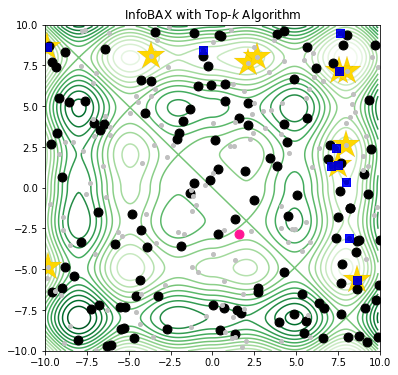

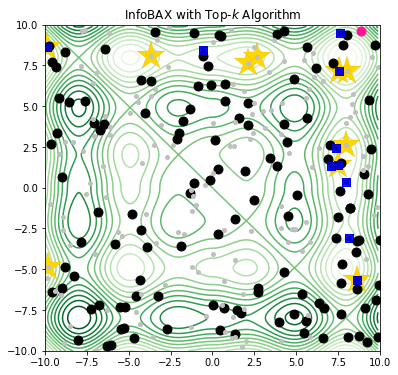

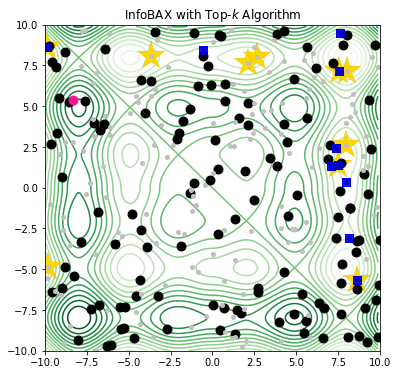

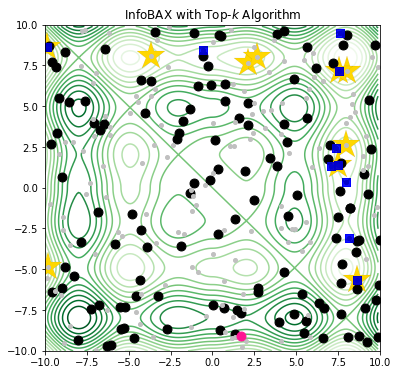

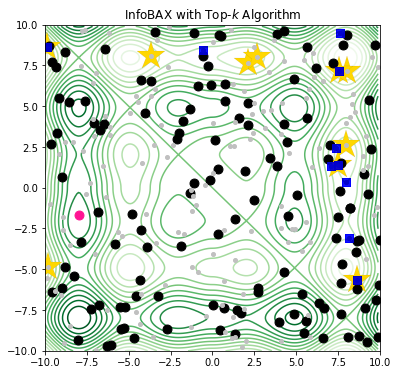

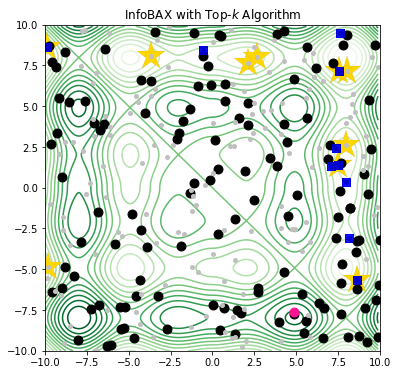

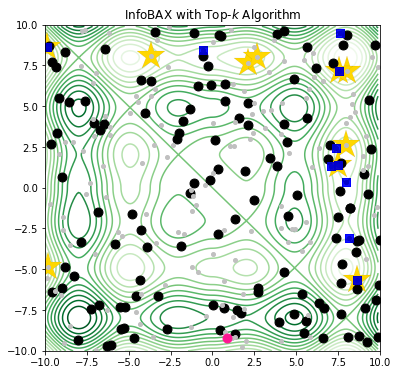

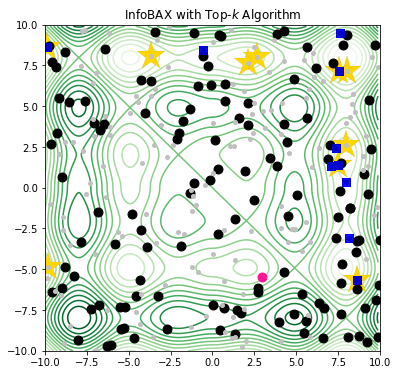

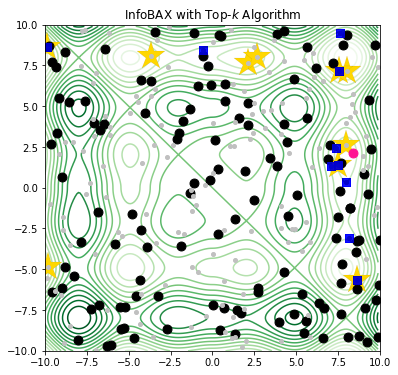

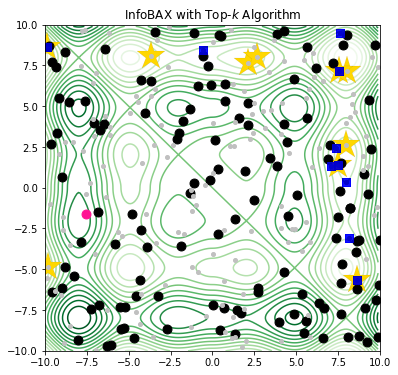

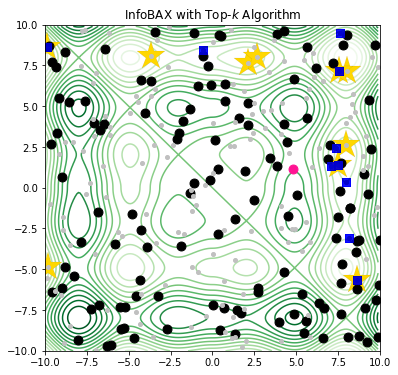

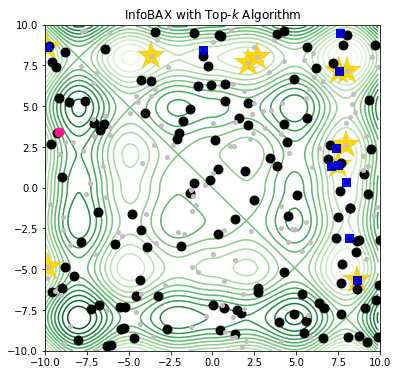

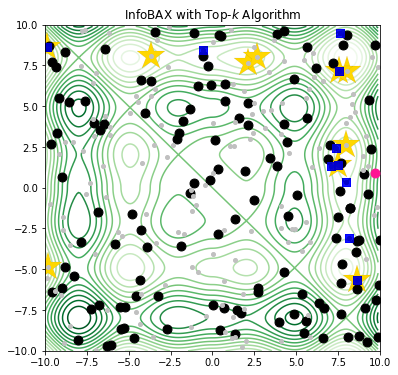

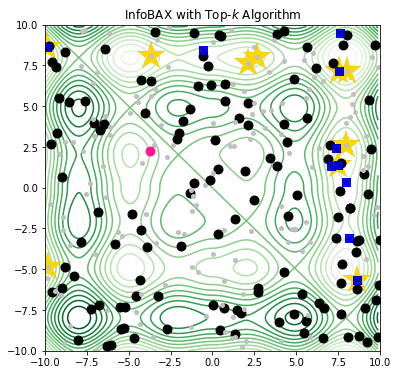

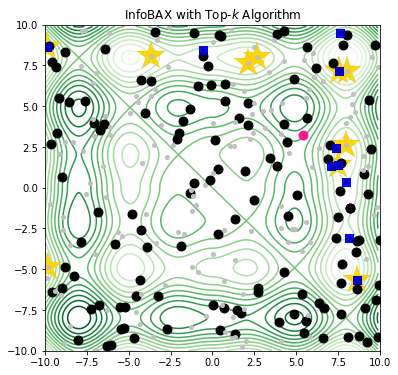

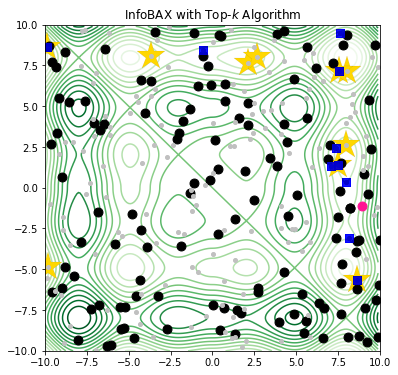

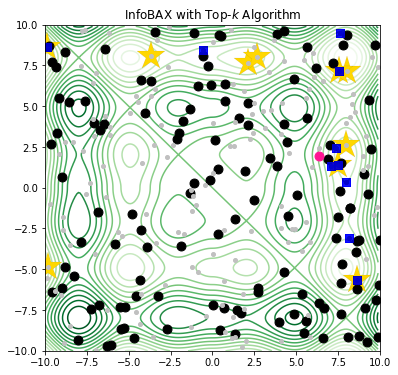

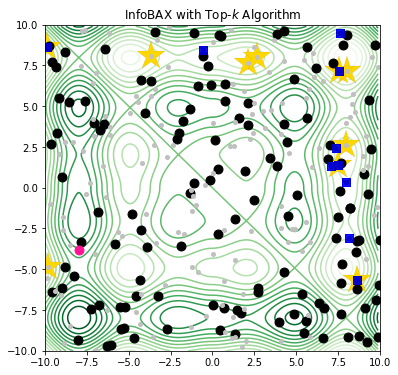

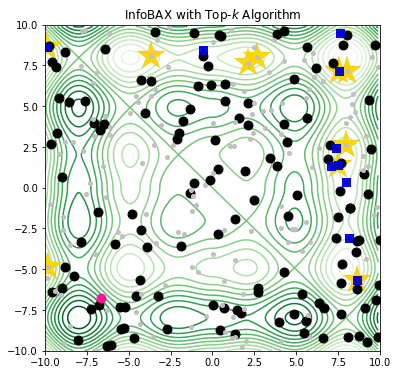

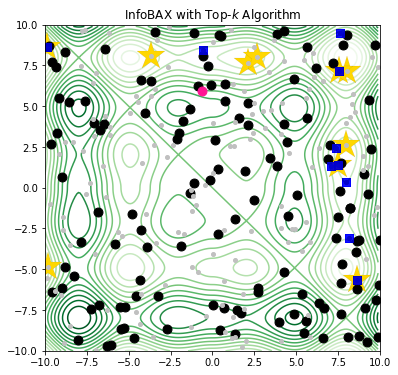

In [268]:
# Run BAX loop
for i in range(20):
    # Set model
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_tr, y_tr, likelihood=likelihood)

    # Set and optimize acquisition function
    acqfn = acq_cls(acqfn_params, model, algo_gt)
    x_test = unif_random_sample_domain(domain, n=n_acqopt)
    acqopt = AcqOptimizer({"x_batch": x_test})
    x_next = acqopt.optimize(acqfn)

    # Get expected metric
    #metric_jacc_list = [metric_jacc(output) for output in acqfn.output_list]
    #metric_norm_list = [metric_norm(output) for output in acqfn.output_list]
    # import pdb; pdb.set_trace()
    #expected_metric_jacc = np.mean(metric_jacc_list)
    #expected_metric_norm = np.mean(metric_norm_list)

    # Print iter info
    print(f"Acqopt x_next = {x_next}")
    print(f"output_list[0] = {acqfn.output_list[0]}")
    #print(f"expected_metric_jacc = {expected_metric_jacc}")
    #print(f"expected_metric_norm = {expected_metric_norm}")
    print(f"Finished iter i = {i}")

    # Update results namespace
    #results.expected_metric_jacc_list.append(expected_metric_jacc)
    #results.expected_metric_norm_list.append(expected_metric_norm)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    # -- plot function contour
    grid = 0.1
    xpts = np.arange(domain[0][0], domain[0][1], grid)
    ypts = np.arange(domain[1][0], domain[1][1], grid)
    X, Y = np.meshgrid(xpts, ypts)
    Z = f_vec(X, Y)
    ax.contour(X, Y, Z, 20, cmap=cm.Greens_r, zorder=0)
    # -- plot top_k
    topk_arr = np.array(output_gt.x)
    ax.plot(
        topk_arr[:, 0],
        topk_arr[:, 1],
        '*',
        marker='*',
        markersize=30,
        color='gold',
        markeredgecolor='black',
        markeredgewidth=0.05,
        zorder=1
    )
    # -- plot x_path
    x_path_arr = np.array(x_path)
    ax.plot(x_path_arr[:, 0], x_path_arr[:, 1], '.', color='#C0C0C0', markersize=8)
    # -- plot observations
    for x in data.x:
        ax.scatter(x[0], x[1], color=(0, 0, 0, 1), s=80)
    # -- plot x_next
    ax.scatter(x_next[0], x_next[1], color='deeppink', s=80, zorder=10)
    # -- plot estimated output
    for out in acqfn.output_list:
        out_arr = torch.stack([k for k in out_arr], 0)
 
        ax.plot(
            out_arr[:, 0], out_arr[:, 1], 's', markersize=8, color='blue', alpha=0.02
        )
    # -- lims, labels, titles, etc
    ax.set(xlim=domain[0], ylim=domain[1])
    ax.set_title("InfoBAX with Top-$k$ Algorithm")

    # Save plot
    img_path = f'topk_{i}'
    plt.savefig(str(img_path))

    # Query function, update data
    y_next = f(x_next)
    X_tr = torch.cat([X_tr, torch.tensor(x_next)[None]], 0)
    y_tr = torch.cat([y_tr, torch.tensor(y_next)[None,None]], 0)

# Save final data
results.data = data

# Pickle results
file_str = f"topk_{args.seed}.pkl"
with open(results_dir / file_str, "wb") as handle:
    pickle.dump(results, handle)
    print(f"Saved results file: {results_dir}/{file_str}")

In [6]:
n_iters = 20

while len(Y_ei) < n_iters:
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

NameError: name 'Y_ei' is not defined

In [ ]:









# Set model details
gp_params = {"ls": 2.5, "alpha": 20.0, "sigma": 1e-2, "n_dimx": n_dim}
modelclass = GpfsGp

# Set acquisition details
acqfn_params = {"acq_str": "exe", "n_path": 100, "crop": True}
acq_cls = BaxAcqFunction

# Set acqopt details
n_acqopt = 1500

# Set up results directory
results_dir = Path("topk_results_rebuttal")
results_dir.mkdir(parents=True, exist_ok=True)

# Set up img directory
img_dir = results_dir /  f'images_{args.seed}'
img_dir.mkdir(parents=True, exist_ok=False)

# Namespace to save results
results = Namespace(
    expected_metric_jacc_list = [], expected_metric_norm_list = []
)


# Run BAX loop
for i in range(args.n_iter):
    # Set model

    model = modelclass(gp_params, data)

    # Set and optimize acquisition function
    acqfn = acq_cls(acqfn_params, model, algo)
    x_test = unif_random_sample_domain(domain, n=n_acqopt)
    acqopt = AcqOptimizer({"x_batch": x_test})
    x_next = acqopt.optimize(acqfn)

    # Get expected metric
    metric_jacc_list = [metric_jacc(output) for output in acqfn.output_list]
    metric_norm_list = [metric_norm(output) for output in acqfn.output_list]
    expected_metric_jacc = np.mean(metric_jacc_list)
    expected_metric_norm = np.mean(metric_norm_list)

    # Print iter info
    print(f"Acqopt x_next = {x_next}")
    print(f"output_list[0] = {acqfn.output_list[0]}")
    print(f"expected_metric_jacc = {expected_metric_jacc}")
    print(f"expected_metric_norm = {expected_metric_norm}")
    print(f"Finished iter i = {i}")

    # Update results namespace
    results.expected_metric_jacc_list.append(expected_metric_jacc)
    results.expected_metric_norm_list.append(expected_metric_norm)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    # -- plot function contour
    grid = 0.1
    xpts = np.arange(domain[0][0], domain[0][1], grid)
    ypts = np.arange(domain[1][0], domain[1][1], grid)
    X, Y = np.meshgrid(xpts, ypts)
    Z = f_vec(X, Y)
    ax.contour(X, Y, Z, 20, cmap=cm.Greens_r, zorder=0)
    # -- plot top_k
    topk_arr = np.array(output_gt.x)
    ax.plot(
        topk_arr[:, 0],
        topk_arr[:, 1],
        '*',
        marker='*',
        markersize=30,
        color='gold',
        markeredgecolor='black',
        markeredgewidth=0.05,
        zorder=1
    )
    # -- plot x_path
    x_path_arr = np.array(x_path)
    ax.plot(x_path_arr[:, 0], x_path_arr[:, 1], '.', color='#C0C0C0', markersize=8)
    # -- plot observations
    for x in data.x:
        ax.scatter(x[0], x[1], color=(0, 0, 0, 1), s=80)
    # -- plot x_next
    ax.scatter(x_next[0], x_next[1], color='deeppink', s=80, zorder=10)
    # -- plot estimated output
    for out in acqfn.output_list:
        out_arr = np.array(out.x)
        ax.plot(
            out_arr[:, 0], out_arr[:, 1], 's', markersize=8, color='blue', alpha=0.02
        )
    # -- lims, labels, titles, etc
    ax.set(xlim=domain[0], ylim=domain[1])
    ax.set_title("InfoBAX with Top-$k$ Algorithm")

    # Save plot
    img_path = img_dir / f'topk_{i}'
    plt.savefig(str(img_path), 'pdf')

    # Query function, update data
    y_next = f(x_next)
    data.x.append(x_next)
    data.y.append(y_next)

# Save final data
results.data = data

# Pickle results
file_str = f"topk_{args.seed}.pkl"
with open(results_dir / file_str, "wb") as handle:
    pickle.dump(results, handle)
    print(f"Saved results file: {results_dir}/{file_str}")